# EDA Dataet Homicidios

Aqui analizaremos el dataset Homocidio que contiene datos policiales que instruye la Policía de la
Ciudad ante dos clases de delitos que involucran la seguridad vial: **lesiones culposas** (Arts. 94 y 94 bis del Código Penal de la Nación) y **homicidios culposos** (Arts. 84 y 84 bis del CPN)

Para ello dividiremos el trabajo en:

* Extraccion: los datos se encuentran en dos tablas distintas
* Analisis Inicial: vemos las columnas de cada tabla
* Combinacion de tablas: unimos ambas tablas a travéz de un dato en comun

Analisis exploratorio de datos (EDA):

* Limpieza (tratamiento de nulos, duplicados y formato de datos)
* Exportacion de datos tratados para su posterior uso
* Analisis sobre los datos obtenidos

## Extraccion de datos

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, time
import folium
from folium import plugins
import json

#Estilo de graficas:
plt.style.use('dark_background')
#Color de fondo
plt.rcParams['figure.facecolor'] = (31/255, 31/255, 31/255)

Los datos se encuentran en un archivo excel (.xlsx) en dos tablas con sus correspondientes diccionarios.

Estas tablas son: hechos y victimas. Cada una separada en una hoja diferente

In [89]:
#Leemos los datos
homicidios_hechos= pd.read_excel('DataSets/Inicial/homicidios.xlsx',sheet_name = 'HECHOS',na_values=['SD', 'sd', 'Sd', 'sD'])
homicidios_victimas= pd.read_excel('DataSets/Inicial/homicidios.xlsx',sheet_name = 'VICTIMAS',na_values=['SD', 'sd', 'Sd', 'sD'])
diccionario_hechos= pd.read_excel('DataSets/Inicial/homicidios.xlsx',sheet_name = 'DICCIONARIO_HECHOS',na_values=['SD', 'sd', 'Sd', 'sD'])
diccionario_victimas=pd.read_excel('DataSets/Inicial/homicidios.xlsx',sheet_name = 'DICCIONARIO_VICTIMAS',na_values=['SD', 'sd', 'Sd', 'sD'])

# Tratamiento del DataFrame Hechos:
## Analisis Inicial:

In [90]:
#Vemos el dataframe leido
homicidios_hechos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     696 non-null    object        
 1   N_VICTIMAS             696 non-null    int64         
 2   FECHA                  696 non-null    datetime64[ns]
 3   AAAA                   696 non-null    int64         
 4   MM                     696 non-null    int64         
 5   DD                     696 non-null    int64         
 6   HORA                   695 non-null    object        
 7   HH                     695 non-null    float64       
 8   LUGAR_DEL_HECHO        695 non-null    object        
 9   TIPO_DE_CALLE          696 non-null    object        
 10  Calle                  695 non-null    object        
 11  Altura                 129 non-null    float64       
 12  Cruce                  525 non-null    object        
 13  Direc

In [91]:
#Y su correspondiente diccionario
diccionario_hechos.drop(columns='Unnamed: 2').head(21)

,variables y definiciones,descripción
0,ID,identificador unico del siniestro
1,N_VICTIMAS,cantidad de víctimas
2,FECHA,fecha en formato dd/mm/aaaa
3,AAAA,año
4,MM,mes
5,DD,día del mes
6,HORA,hora del siniestro
7,HH,franja horaria entera
8,LUGAR_DEL_HECHO,Dirección del hecho
9,TIPO_DE_CALLE,Tipo de arteria. En el caso de intersecciones ...


Junto con el diccionario de esta tabla podemos ver que tenemos columnas que hacen referencia al mismo dato:

* A la fecha del hecho: 'FECHA, ''AAAA', 'MM', 'DD', 'HORA', 'HH'
* Al lugar exacto del hecho: 'LUGAR_DEL_HECHO', 'CALLE', 'ALTURA', 'CRUCE', 'Direccion Normalizada', 'XY (CABA)', 'POS X', 'POS Y'
* Involucrados: 'PARTICIPANTES'. Siendo la conjuncion de: 'VICTIMA', 'ACUSADO'

### **Eliminacion de columnas:**

'AAAA', 'MM', 'DD', 'HORA', 'HH': Correspondientes a año, mes, dia y hora del hecho (Estos se encuentran en 'FECHA')

In [92]:
homicidios_hechos[['FECHA', 'AAAA', 'MM', 'DD','HORA', 'HH']].head(1)

,FECHA,AAAA,MM,DD,HORA,HH
0,2016-01-01,2016,1,1,04:00:00,4.0


In [93]:
#Comprobemos cantidad de nulos por columna
homicidios_hechos[['FECHA', 'AAAA', 'MM', 'DD','HORA', 'HH']].isnull().sum()

FECHA    0
AAAA     0
MM       0
DD       0
HORA     1
HH       1
dtype: int64

Como las columnas de fecha contienen el formato correcto y no poseen nulos, podemos descartar las redundantes

In [94]:
#Eliminar columnas:
homicidios_hechos.drop(columns=['AAAA', 'MM', 'DD',], inplace=True)

Como 'FECHA' no contiene la hora del suceso analizemos 'HH' y 'HORA':

HH: Contiene franja horaria entera

HORA: Contiene hora del siniestro

In [95]:
#Hagamos una comparacion de nulos:
homicidios_hechos[['HH', 'HORA']].isnull().sum()

HH      1
HORA    1
dtype: int64

In [96]:
#Veamos si comparten el mismo nulo
homicidios_hechos[['ID','HH', 'HORA']][homicidios_hechos[['HH', 'HORA']].isnull().any(axis=1)]

,ID,HH,HORA
518,2019-0103,NaN,NaN


In [97]:
#Como lo hacen, podemos eliminar la columna HH
homicidios_hechos.drop(columns='HH', inplace=True)

**Tenemos varias columnas que hacen referencia al lugar de los hechos:**

LUGAR_DEL_HECHO: Dirección del hecho

Calle: nombre de la arteria donde se produjo el hecho

Altura: altura de la arteria donde se produjo el hecho

Cruce: cruce en caso de que sea una encrucijada

Dirección Normalizada: direccion en formato normalizado USIG

XY (CABA): geocodificación plana

pos x: longitud con separador punto.

pos y: latitud con separador punto.


In [98]:
#Hagamos una comparacion de nulos:
homicidios_hechos[['LUGAR_DEL_HECHO', 'TIPO_DE_CALLE',
       'Calle', 'Altura', 'Cruce', 'Dirección Normalizada', 'COMUNA',
       'XY (CABA)', 'pos x', 'pos y']].isnull().sum()

LUGAR_DEL_HECHO            1
TIPO_DE_CALLE              0
Calle                      1
Altura                   567
Cruce                    171
Dirección Normalizada      8
COMUNA                     0
XY (CABA)                  0
pos x                      0
pos y                      0
dtype: int64

In [99]:
#Veamos los nulos para 'Dirección Normalizada'
homicidios_hechos[homicidios_hechos[['Dirección Normalizada']].isnull().any(axis=1)].head(3)

,ID,N_VICTIMAS,FECHA,HORA,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
38,2016-0052,1,2016-04-20,20:00:00,AUTOPISTA LUGONES PK 10000,AUTOPISTA,"LUGONES, LEOPOLDO AV.",NaN,NaN,NaN,13,Point (. .),.,.,MOTO-SD,MOTO,NaN
106,2016-0136,1,2016-10-25,00:00:00,AU BUENOS AIRES - LA PLATA KM. 4,AUTOPISTA,AUTOPISTA BUENOS AIRES - LA PLATA,NaN,NaN,NaN,4,Point (. .),.,.,MOTO-CARGAS,MOTO,CARGAS
119,2016-0151,1,2016-11-18,20:35:00,NaN,CALLE,NaN,NaN,NaN,NaN,0,Point (. .),.,.,PEATON-SD,PEATON,NaN


Podemos ver que hay valores vacios en 'pos x', 'pos y' y 'XY (CABA)'

Quitemos estos valores

In [100]:
#Quitamos '.' de pos x , pos y
homicidios_hechos[['pos x', 'pos y']]=homicidios_hechos[['pos x', 'pos y']].replace('.', pd.NA)

In [101]:
#Quitamos 'Point (. .)' de XY (CABA)
homicidios_hechos[['XY (CABA)']]=homicidios_hechos[['XY (CABA)']].replace('Point (. .)', pd.NA)

In [102]:
#Veamos cuantos nulos obtenemos
homicidios_hechos[['LUGAR_DEL_HECHO', 'TIPO_DE_CALLE',
       'Calle', 'Altura', 'Cruce', 'Dirección Normalizada',
       'XY (CABA)', 'pos x', 'pos y']].isnull().sum()

LUGAR_DEL_HECHO            1
TIPO_DE_CALLE              0
Calle                      1
Altura                   567
Cruce                    171
Dirección Normalizada      8
XY (CABA)                 14
pos x                     12
pos y                     12
dtype: int64

Usemos 'pos x' y 'pos y' para obtener el lugar de los hechos, Calle y TIPO_DE_CALLE para un analisis 

Descartando las demas columnas

In [103]:
homicidios_hechos.drop(columns=['LUGAR_DEL_HECHO', 'Altura', 'Cruce',
                                'Dirección Normalizada',
                                'XY (CABA)'], inplace=True)

Veamos si participantes contiene correctamente las columnas victima-acusado

In [104]:
#Separamos los datos de 'PARTICIPANTES'
separado=homicidios_hechos.PARTICIPANTES.str.split('-', expand=True)

In [105]:
#Veamos si hay valores que no coincidan con 'Victimas'
separado[separado[0]!=homicidios_hechos['VICTIMA']][0].head()

31    MULTIPLE
35          SD
76          SD
88          SD
92          SD
Name: 0, dtype: object

In [106]:
#Veamos un ejemplo
homicidios_hechos[['PARTICIPANTES', 'VICTIMA', 'ACUSADO']].iloc[31]

PARTICIPANTES    MULTIPLE
VICTIMA              MOTO
ACUSADO          MULTIPLE
Name: 31, dtype: object

Vemos que la columna PARTICIPANTES no tiene el dato de VICTIMA

In [107]:
#Veamos si contiene datos de los valores nulos en VICTIMA:
homicidios_hechos[['PARTICIPANTES', 'VICTIMA']][homicidios_hechos['VICTIMA'].isnull()]

,PARTICIPANTES,VICTIMA
35,SD-SD,NaN
76,SD-SD,NaN
88,SD-CARGAS,NaN
92,SD-SD,NaN
139,SD-SD,NaN
164,SD-AUTO,NaN
201,SD-SD,NaN
214,SD-AUTO,NaN
269,SD-MOTO,NaN


Podemos ver que la columna participantes no contiene valores nulos de VICTIMA, y tambien tiene faltantes de esta

Ahora veamos la columna acusado

In [108]:
#Veamos si hay valores que no coincidan con 'Acusado'
filtro=separado[(separado[1])!=homicidios_hechos['ACUSADO']]
filtro[filtro[(filtro!='SD')][1].notna()][1]

62           MOVIL
230    OBJETO FIJO
333          MOVIL
371          MOVIL
Name: 1, dtype: object

In [109]:
#Veamos un ejemplo
homicidios_hechos[['PARTICIPANTES', 'VICTIMA', 'ACUSADO']].iloc[[62,230,333,371]]

,PARTICIPANTES,VICTIMA,ACUSADO
62,MOTO-MOVIL,MOTO,OTRO
230,AUTO-OBJETO FIJO,OBJETO FIJO,AUTO
333,MOTO-MOVIL,MOTO,OTRO
371,AUTO-MOVIL,AUTO,OTRO


Podemos ver que estos datos de PARTICIPANTES son diferentes a ACUSADO

Veamos si PARTICIPANTES tiene nulos de ACUSADO

In [110]:
#Mostramos nulos
homicidios_hechos[['PARTICIPANTES', 'ACUSADO']][homicidios_hechos['ACUSADO'].isnull()]

,PARTICIPANTES,ACUSADO
3,MOTO-SD,NaN
32,MOTO-SD,NaN
35,SD-SD,NaN
38,MOTO-SD,NaN
57,AUTO-SD,NaN
76,SD-SD,NaN
83,PEATON-SD,NaN
92,SD-SD,NaN
105,PEATON-SD,NaN
112,MOTO-SD,NaN


Como participantes no contiene nulos de VICTIMA o ACUSADO. Y tambien contiene algunas discrepancias
Hemos optado por borrar esta columnas, y trabajar con VICTIMA y ACUSADO

In [111]:
homicidios_hechos.drop(columns='PARTICIPANTES', inplace=True)

## Ahora veamos el segundo Dataframe 'Victimas':
## Analisis Inicial:

In [112]:
#DataFrame Leido
homicidios_victimas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_hecho             717 non-null    object        
 1   FECHA                717 non-null    datetime64[ns]
 2   AAAA                 717 non-null    int64         
 3   MM                   717 non-null    int64         
 4   DD                   717 non-null    int64         
 5   ROL                  706 non-null    object        
 6   VICTIMA              708 non-null    object        
 7   SEXO                 711 non-null    object        
 8   EDAD                 664 non-null    float64       
 9   FECHA_FALLECIMIENTO  649 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 56.1+ KB


In [113]:
#Y su correspondiente diccionario
diccionario_victimas.drop(columns='Unnamed: 2').head(10)

,variables y definiciones,descripción
0,ID_hecho,identificador unico del siniestro
1,FECHA,fecha en formato dd/mm/aaaa
2,AAAA,año
3,MM,mes
4,DD,día del mes
5,ROL,Posición relativa al vehículo que presentaba l...
6,VICTIMA,Vehículo que ocupaba quien haya fallecido a se...
7,SEXO,Sexo informado por fuente policial de la víctima
8,EDAD,Edad de la víctima al momento del siniestro
9,FECHA_FALLECIMIENTO,Fecha de fallecimiento de la víctima


Junto con el diccionario de esta tabla podemos ver que tenemos columnas que hacen referencia al mismo dato:

Fecha del hecho: 'FECHA, ''AAAA', 'MM', 'DD'

### **Eliminacion de columnas:**

Comprobemos cantidad de nulos por columna

In [114]:
homicidios_victimas[['FECHA', 'AAAA', 'MM', 'DD']].isnull().sum()

FECHA    0
AAAA     0
MM       0
DD       0
dtype: int64

Quedemonos solo con la columna Fecha

In [115]:
#Eliminar columnas:
homicidios_victimas.drop(columns=['AAAA', 'MM', 'DD'], inplace=True)

In [116]:
# Veamos nulos en FECHA_FALLECIMIENTO
homicidios_victimas.isnull().sum()

ID_hecho                0
FECHA                   0
ROL                    11
VICTIMA                 9
SEXO                    6
EDAD                   53
FECHA_FALLECIMIENTO    68
dtype: int64

Y eliminemos columnas que no utilizaremos en nuestro analisis

In [117]:
homicidios_victimas.drop(columns=['ROL'], inplace=True)

In [118]:
homicidios_victimas.columns

Index(['ID_hecho', 'FECHA', 'VICTIMA', 'SEXO', 'EDAD', 'FECHA_FALLECIMIENTO'], dtype='object')

### Ahora unamos estos dos DataFrames para formar un solo DataSet de Homicidios
Antes de hacerlo necesitamos renombrar las columnas que contienen datos iguales en ambas tablas, estas son:

'FECHA' y 'VICTIMA'

In [119]:
#Renombramos FECHA y VICTIMA
homicidios_victimas.rename(columns={'FECHA':'FECHA_VICTIMA', 'VICTIMA':'VICTIMA_VICTIMA'}, inplace=True)

In [120]:
#Usamos el merge en left para unir todas las victimas con sus correspondientes hechos
homicidios=pd.merge(homicidios_victimas,homicidios_hechos, left_on='ID_hecho', right_on='ID', how='left')

In [121]:
print('Columnas:')
print(homicidios.columns.tolist())

Columnas:
['ID_hecho', 'FECHA_VICTIMA', 'VICTIMA_VICTIMA', 'SEXO', 'EDAD', 'FECHA_FALLECIMIENTO', 'ID', 'N_VICTIMAS', 'FECHA', 'HORA', 'TIPO_DE_CALLE', 'Calle', 'COMUNA', 'pos x', 'pos y', 'VICTIMA', 'ACUSADO']


Tenemos Columnas que representan el mismo valor:

* ID, ID_hecho
* FECHA; FECHA_VICTIMA
* VICTIMA, VICTIMA_VICTIMA

Estas corresponden a Hechos y Victimas correspondientemente. Veamos que hacer con ellos:

Nos quedamos con ID para poder agrupar y tener la cantidad de homicidios

In [122]:
#Eliminar ID y ID_hecho
homicidios.drop(columns=['ID_hecho'], inplace=True)

Veamos si los nulos de VICTIMA son los mismos de VICTIMA_VICTIMA. Siendo:

VICTIMA_VICTIMA el valor de la tabla Victimas

VICTIMA el valor de la tabla Hechos

In [123]:
print('Nulos en VICTIMA:', homicidios['VICTIMA'].isnull().sum())

Nulos en VICTIMA: 9


In [124]:
print('Nulos en VICTIMA_VICTIMA: ')
print(homicidios['VICTIMA_VICTIMA'].isnull().sum())

Nulos en VICTIMA_VICTIMA: 
9


In [125]:
#Veamos los nulos en ambas columnas
print('Cantidad de nulos en ambas columnas:')
print(len(homicidios[['VICTIMA','VICTIMA_VICTIMA']][homicidios['VICTIMA'].isnull()&homicidios['VICTIMA_VICTIMA'].isnull()]))
homicidios[['VICTIMA','VICTIMA_VICTIMA']][homicidios['VICTIMA'].isnull()&homicidios['VICTIMA_VICTIMA'].isnull()]

Cantidad de nulos en ambas columnas:
9


,VICTIMA,VICTIMA_VICTIMA
36,NaN,NaN
77,NaN,NaN
89,NaN,NaN
93,NaN,NaN
141,NaN,NaN
167,NaN,NaN
208,NaN,NaN
221,NaN,NaN
280,NaN,NaN


Vemos que no podemos obtener nulos de ninguna columna.

Veamos las diferencias entre estas columnas

In [126]:
homicidios[['VICTIMA','VICTIMA_VICTIMA']][(homicidios['VICTIMA']!=homicidios['VICTIMA_VICTIMA'])&(homicidios['VICTIMA'].notna())]

,VICTIMA,VICTIMA_VICTIMA
237,OBJETO FIJO,AUTO
238,OBJETO FIJO,AUTO
602,PEATON_MOTO,PEATON
603,PEATON_MOTO,MOTO


Como en el diccionario no aparece el termino 'PEATON_MOTO' y 'OBJETO FIJO' es un valor correspondiente a ACUSADO. 

Nos quedamos con VICTIMA_VICTIMA, de ahora en mas 'victima'

In [127]:
#Eliminamos VICTIMA
homicidios.drop(columns='VICTIMA', inplace=True)
#Renombramos VICTIMA_VICTIMA
homicidios.rename(columns={'VICTIMA_VICTIMA':'victima'}, inplace=True)

Sabemos que no hay nulos en FECHA o FECHA_VICTIMA.

Por lo tanto veamos si hay diferencias:

In [128]:
#Veamos los nulos en ambas columnas
print('Cantidad de nulos en ambas columnas:')
print(len(homicidios[['FECHA','FECHA_VICTIMA']][homicidios['FECHA'].isnull()&homicidios['FECHA_VICTIMA'].isnull()]))

Cantidad de nulos en ambas columnas:
0


In [129]:
#Diferencias entre columnas
homicidios[['FECHA','FECHA_VICTIMA', 'FECHA_FALLECIMIENTO']][(homicidios['FECHA']!=homicidios['FECHA_VICTIMA'])&(homicidios['FECHA'].notna())]

,FECHA,FECHA_VICTIMA,FECHA_FALLECIMIENTO
65,2016-07-02,2016-07-03,2016-07-03 00:00:00
204,2017-05-24,2017-05-29,2017-05-29 00:00:00


Tenemos que tener cuidado al elegir la columna, ya que esto podría indicar una muerte en el momento, o en el hospital donde fue tratato.

Para esto carguemos nuevamente los datasets y comparemos estas fechas con otras columnas

In [130]:
#Cargamos el dataframe
homicidios_hechos= pd.read_excel('DataSets/Inicial/homicidios.xlsx',sheet_name = 'HECHOS',na_values=['SD', 'sd', 'Sd', 'sD'])
#Vemos la fecha distintta
homicidios_hechos[['FECHA','AAAA', 'MM', 'DD']][homicidios_hechos.FECHA=='2016-07-02']

,FECHA,AAAA,MM,DD
64,2016-07-02,2016,7,3


Notamos una discrepancia en la columna FECHA

In [131]:
#Cargamos el dataframe
homicidios_victimas= pd.read_excel('DataSets/Inicial/homicidios.xlsx',sheet_name = 'VICTIMAS',na_values=['SD', 'sd', 'Sd', 'sD'])
#Vemos la fecha distintta
homicidios_victimas[['FECHA','AAAA', 'MM', 'DD']][homicidios_victimas.FECHA=='2017-05-29']

,FECHA,AAAA,MM,DD
204,2017-05-29,2017,5,29


No notamos discrepancias para el segundo valor

Decidimos quedarnos con la columna FECHA_VICTIMAS (De ahora en mas FECHA) que contiene menos errores

In [132]:
#Eliminamos FECHA
homicidios.drop(columns='FECHA', inplace=True)
#Renombramos
homicidios.rename(columns={'FECHA_VICTIMA':'FECHA'}, inplace=True)

Por ultimo renombramos columnas

In [133]:
#Normalizamos los nombres de las columnas
homicidios.rename(columns={'FECHA':'fecha', 'VICTIMA':'victima',
       'FECHA_FALLECIMIENTO':'fecha_fallecimiento','N_VICTIMAS':'n_victimas', 'EDAD': 'edad', 'SEXO':'sexo',
       'HORA': 'hora', 'TIPO_DE_CALLE':'tipo_calle', 'Calle':'calle', 'COMUNA': 'comuna',
       'pos x':'longitud', 'pos y':'latitud', 'ACUSADO':'acusado'}, inplace=True)

<center>

# EDA

</center>

### Ahora que tenemos nuestro DataSet, hagamos un Analisis Exploratorio de estos Datos:

        Formato

Veamos el tipo de dato que contienen nuestras columnas

In [134]:
homicidios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   fecha                717 non-null    datetime64[ns]
 1   victima              708 non-null    object        
 2   sexo                 711 non-null    object        
 3   edad                 664 non-null    float64       
 4   fecha_fallecimiento  649 non-null    object        
 5   ID                   717 non-null    object        
 6   n_victimas           717 non-null    int64         
 7   hora                 716 non-null    object        
 8   tipo_calle           717 non-null    object        
 9   calle                716 non-null    object        
 10  comuna               717 non-null    int64         
 11  longitud             704 non-null    object        
 12  latitud              704 non-null    object        
 13  acusado              694 non-null  

victima, sexo, tipo_calle , comuna y acusado son variables categoricas que figuran como 'object'. 

Corrijamos esto, no sin antes checar las categorias

In [135]:
#victima contiene correctamente las categorias
homicidios.victima.unique()

array(['MOTO', 'AUTO', 'PEATON', nan, 'CARGAS', 'BICICLETA', 'PASAJEROS',
       'MOVIL'], dtype=object)

In [136]:
#sexo contiene correctamente las categorias
homicidios.sexo.unique()

array(['MASCULINO', 'FEMENINO', nan], dtype=object)

In [137]:
homicidios.loc[:,'tipo_calle']

0        AVENIDA
1       GRAL PAZ
2        AVENIDA
3        AVENIDA
4        AVENIDA
         ...    
712      AVENIDA
713      AVENIDA
714    AUTOPISTA
715      AVENIDA
716      AVENIDA
Name: tipo_calle, Length: 717, dtype: object

In [138]:
#GRAL PAZ no es un tipo de calle, cambiemos esta a AUTOPISTA
#Vemos las categorias
print(homicidios.tipo_calle.unique())
#Cambiamos GRAL PAZ
homicidios.loc[homicidios['tipo_calle'] == 'GRAL PAZ', 'tipo_calle'] = 'AUTOPISTA'

['AVENIDA' 'GRAL PAZ' 'CALLE' 'AUTOPISTA']


In [139]:
#comuna tiene un valor '0' que no es corespondiente. Lo dejaremos ya que no influye mucho en nuestro analisis
homicidios.comuna.unique()

array([ 8,  9,  1, 11, 15,  4,  7, 12,  3, 13, 14, 10,  6,  2,  5,  0],
      dtype=int64)

In [140]:
#acusado contiene correctamente las categorias
homicidios.acusado.unique()

array(['AUTO', 'PASAJEROS', nan, 'OBJETO FIJO', 'CARGAS', 'MOTO',
       'MULTIPLE', 'OTRO', 'BICICLETA', 'TREN'], dtype=object)

In [141]:
homicidios.victima=homicidios.victima.astype('category')
homicidios.sexo=homicidios.sexo.astype('category')
homicidios.tipo_calle=homicidios.tipo_calle.astype('category')
homicidios.comuna=homicidios.comuna.astype('category')
homicidios.acusado=homicidios.acusado.astype('category')

fecha_fallecimiento es un tipo date y su formato es dd/mm/aaaa como lo dice en el diccionario

In [142]:
homicidios.fecha_fallecimiento=pd.to_datetime(homicidios.fecha_fallecimiento, format='%d/%m/%Y', errors='coerce')

cambiemos el formato objeto ('objet') a hora (datime . time) de la columna hora

In [143]:
# Convertir la columna a datetime.time y extraer la parte del tiempo
homicidios['hora'] = pd.to_datetime(homicidios['hora'], format='%H:%M:%S').dt.time

Por ultimo transformemos las columnas latitud y longitud en decimal. Y Edad en int

In [144]:
homicidios.latitud=pd.to_numeric(homicidios.latitud)
homicidios.longitud=pd.to_numeric(homicidios.longitud)
homicidios.edad=pd.to_numeric(homicidios.edad)

In [145]:
#Veamos el resultado
homicidios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   fecha                717 non-null    datetime64[ns]
 1   victima              708 non-null    category      
 2   sexo                 711 non-null    category      
 3   edad                 664 non-null    float64       
 4   fecha_fallecimiento  649 non-null    datetime64[ns]
 5   ID                   717 non-null    object        
 6   n_victimas           717 non-null    int64         
 7   hora                 716 non-null    object        
 8   tipo_calle           717 non-null    category      
 9   calle                716 non-null    object        
 10  comuna               717 non-null    category      
 11  longitud             704 non-null    float64       
 12  latitud              704 non-null    float64       
 13  acusado              694 non-null  

        DUPLICADOS:

In [146]:
print('Total de filas', len(homicidios))
print('Total de filas duplicadas', len(homicidios[homicidios.duplicated()]))

Total de filas 717
Total de filas duplicadas 0


Corregiremos algunos errores en la columna calle:

In [147]:
#Correcciones:
homicidios.loc[homicidios['calle']=='ACOSTA, MARIANO', 'calle']='ACOSTA, MARIANO AV.'
homicidios.loc[homicidios['calle']=='NU?EZ', 'calle']='NUÑEZ.'
homicidios.loc[homicidios['calle']=='CASTA?ARES AV.', 'calle']='CASTAÑARES AV.'
homicidios.loc[homicidios['calle']=='ALBARI?O', 'calle']='ALBARIÑO.'
homicidios.loc[homicidios['calle']=='AUTOPISTA PRESIDENTE H?CTOR J. C?MPORA', 'calle']='AUTOPISTA PRESIDENTE HECTOR J. CAMPORA.'
homicidios.loc[homicidios['calle']=='MU?ECAS', 'calle']='MUÑECAS'
homicidios.loc[homicidios['calle']=='RODRIGUEZ PE?A', 'calle']='RODRIGUEZ PEÑA'
homicidios.loc[homicidios['calle']=='ARAOZ DE LAMADRID, GREGORIO, GRAL.', 'calle']='ARAOZ'


        NULOS

**Podemos ver que los nulos que tenemos en cada columna, son muy pocos:**

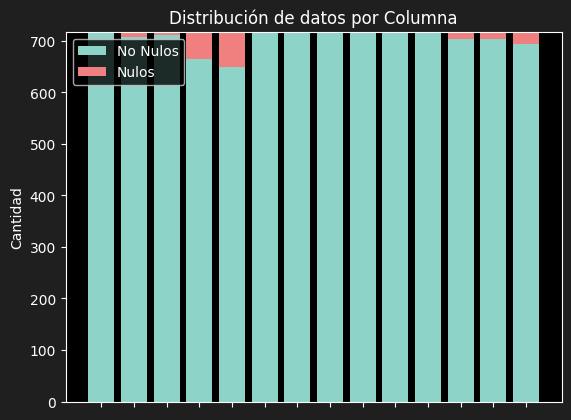

In [148]:
# Inicializar listas para almacenar los valores nulos y no nulos
valores_nulos = []
valores_no_nulos = []

# Iterar sobre las columnas del DataFrame
for columna in homicidios.columns:
    valores_nulos.append(homicidios[columna].isnull().sum())
    valores_no_nulos.append(homicidios[columna].count())

# Crear el gráfico de barras apiladas
fig, ax = plt.subplots()

# Barra de valores no nulos
ax.bar(homicidios.columns, valores_no_nulos, label='No Nulos')

# Barra de valores nulos apilada encima
ax.bar(homicidios.columns, valores_nulos, bottom=valores_no_nulos, label='Nulos',color='lightcoral')

# Configurar leyenda y etiquetas
ax.legend()
ax.set_ylabel('Cantidad')
ax.set_title('Distribución de datos por Columna')
ax.set_xticklabels([])

# Mostrar el gráfico
plt.show()

Los nulos en FECHA_FALLECIMIENTO corresponden a 'lesiones culposas' segun las [Notas de Uso](https://cdn.buenosaires.gob.ar/datosabiertos/datasets/transporte-y-obras-publicas/victimas-siniestros-viales/NOTAS_HOMICIDIOS_SINIESTRO_VIAL.pdf) del dataframe Víctimas Fatales en Siniestros Viales.

Como este analisis se hace sobre los homicidios en siniestros viales. Podemos descartar estos nulos

In [149]:
#Quitamos nulos de FECHA_FALLECIMIENTO
homicidios.dropna(subset=['fecha_fallecimiento'], inplace=True)

Veamos los nulos resultantes en porcentaje

In [150]:
#Porcentaje de nulos por columna:
print((homicidios.isnull().sum()[homicidios.isnull().sum() > 0] / len(homicidios)) * 100)

victima     0.308166
edad        5.855162
hora        0.154083
longitud    1.386749
latitud     1.386749
acusado     1.694915
dtype: float64


#### La cantidad de nulos en la columna edad es muy grande como para pasarlo por alto:

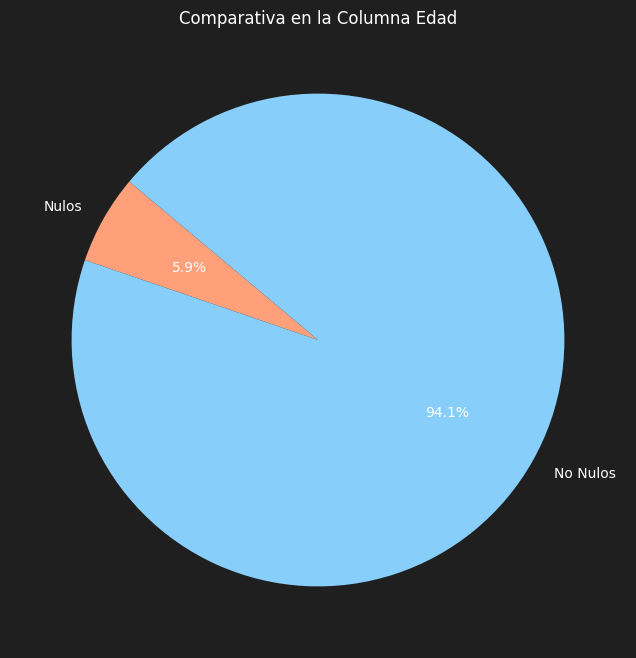

In [151]:
# Contar valores nulos y no nulos
nulos = homicidios['edad'].isna().sum()
no_nulos = homicidios['edad'].notna().sum()

# Crear un gráfico de pastel
plt.figure(figsize=(8, 8))
plt.pie([nulos, no_nulos], labels=['Nulos', 'No Nulos'], autopct='%1.1f%%', startangle=140, colors=['lightsalmon', 'lightskyblue'])
plt.title('Comparativa en la Columna Edad')
plt.show()

Veamos con que valor podemos rellenar este campo.

In [152]:
homicidios['edad'].describe()

count    611.000000
mean      42.582651
std       19.964665
min        1.000000
25%       27.000000
50%       37.000000
75%       57.000000
max       95.000000
Name: edad, dtype: float64

Utilizaremos la media para rellenar estos nulos

In [153]:
# Calcula la media de la columna 'Edad' (excluyendo los NaN)
media_edad = homicidios['edad'].median()

# Rellena los valores nulos en la columna 'Edad' con la media
homicidios['edad'].fillna(media_edad, inplace=True)

#Convertimos la columna en entero:
homicidios['edad'] = homicidios['edad'].astype(int)

### Veamos los nulos de las demas columnas:

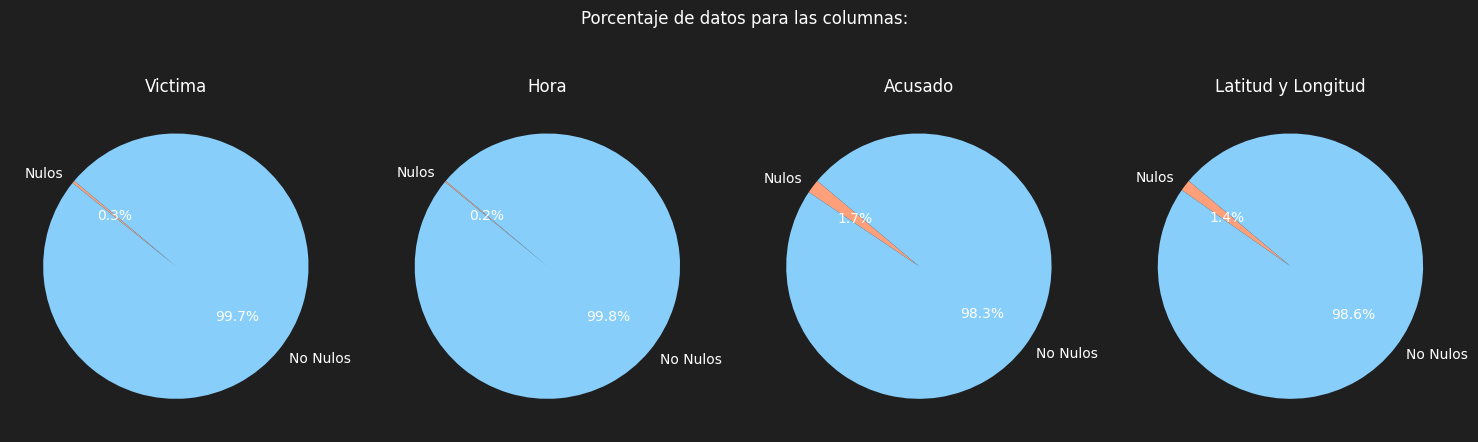

In [154]:
# Lista de columnas para las cuales deseas crear gráficos de pastel
columnas_a_graficar = ['victima', 'hora', 'acusado', 'latitud']

# Configuración de la figura
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].pie([homicidios.victima.isnull().sum(), homicidios.victima.notnull().sum()], 
           labels=['Nulos', 'No Nulos'], autopct='%1.1f%%', startangle=140, colors=['lightsalmon', 'lightskyblue'])
axs[0].set_title(f'Victima')
axs[1].pie([homicidios.hora.isnull().sum(), homicidios.hora.notnull().sum()], 
           labels=['Nulos', 'No Nulos'], autopct='%1.1f%%', startangle=140, colors=['lightsalmon', 'lightskyblue'])
axs[1].set_title(f'Hora')
axs[2].pie([homicidios.acusado.isnull().sum(),homicidios.acusado.notnull().sum()], 
           labels=['Nulos', 'No Nulos'], autopct='%1.1f%%', startangle=140, colors=['lightsalmon', 'lightskyblue'])
axs[2].set_title(f'Acusado')
axs[3].pie([homicidios.latitud.isnull().sum(), homicidios.latitud.notnull().sum()], 
           labels=['Nulos', 'No Nulos'], autopct='%1.1f%%', startangle=140, colors=['lightsalmon', 'lightskyblue'])
axs[3].set_title(f'Latitud y Longitud')

#Ajustar titulo
plt.suptitle('Porcentaje de datos para las columnas:')

# Ajustar el diseño de los subgráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

Como podemos ver estos nulos son muy pocos, por lo que podemos descartarlos sin que influyan en nuestra data

In [155]:
#Eliminar nulos
homicidios.dropna(subset=['victima', 'hora', 'acusado', 'latitud', 'longitud'], inplace=True)

In [156]:
homicidios.iloc[376]

fecha                      2019-03-19 00:00:00
victima                                   MOTO
sexo                                 MASCULINO
edad                                        32
fecha_fallecimiento        2019-03-19 00:00:00
ID                                   2019-0024
n_victimas                                   1
hora                                  07:12:00
tipo_calle                             AVENIDA
calle                  ANTARTIDA ARGENTINA AV.
comuna                                       1
longitud                            -58.372081
latitud                              -34.58542
acusado                                 CARGAS
Name: 459, dtype: object

## Exportamos el DataSet resultante

In [157]:
homicidios.to_csv("DataSets/Limpio/homicidios.csv", index=False)

<center>

# Veamos como se distribuyen los datos
</center>

Utilizando la libreria folium, podemos hacer facilmente una representacion de los homicidios en un mapa:

In [158]:
# Crear un mapa centrado en las coordenadas iniciales
mapa = folium.Map(location=[homicidios['latitud'].mean(), homicidios['longitud'].mean()], zoom_start=12)

# Agregar un marcador para cada fila en el DataFrame con ícono de punto
for index, row in homicidios.iterrows():
    folium.CircleMarker(
        location=[row['latitud'], row['longitud']], color='blue', radius=2
    ).add_to(mapa)

# Guardar el mapa en un archivo HTML
mapa.save('mapa_puntos.html')

<center>

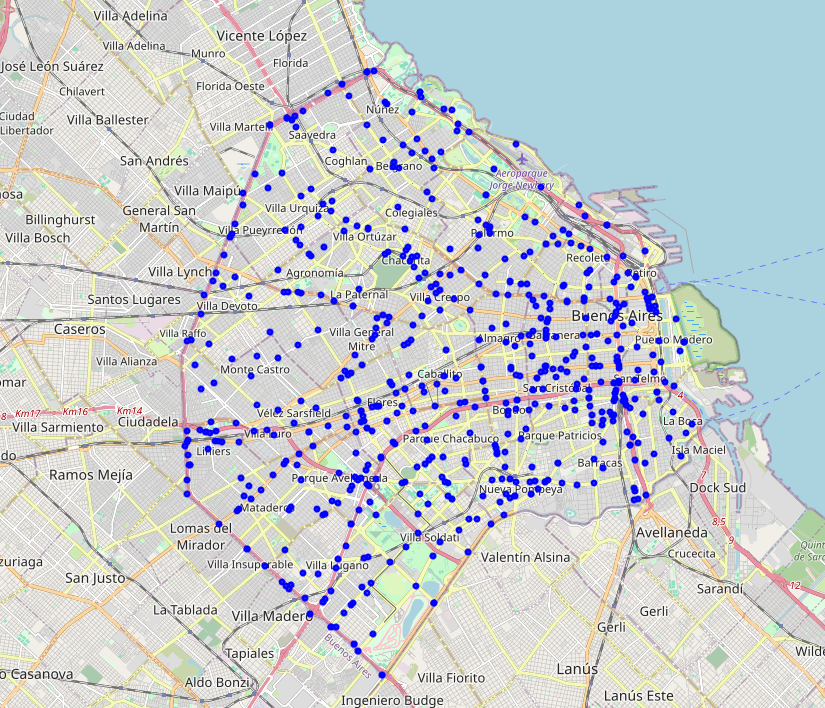

</center>

In [159]:
# Crear un mapa centrado en las coordenadas iniciales
mapa = folium.Map(location=[homicidios['latitud'].mean(), homicidios['longitud'].mean()], zoom_start=12)

# Crear un MarkerCluster para agrupar círculos cercanos
marker_cluster = plugins.MarkerCluster().add_to(mapa)

# Agregar círculos al mapa
for index, row in homicidios.iterrows():
    # Calcular el tamaño del círculo según la cantidad de filas dentro del círculo
    radio = len(homicidios	[(homicidios['latitud'] == row['latitud']) & (homicidios['longitud'] == row['longitud'])])

    # Crear un círculo con el tamaño calculado
    folium.CircleMarker(
        location=[row['latitud'], row['longitud']],
        radius=radio,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7
    ).add_to(marker_cluster)

# Guardar el mapa en un archivo HTML
mapa.save('mapa_circulos_agrupados.html')

<center> Aqui podemos ver las zonas en las que se realizaron mas homicidios

<center> 

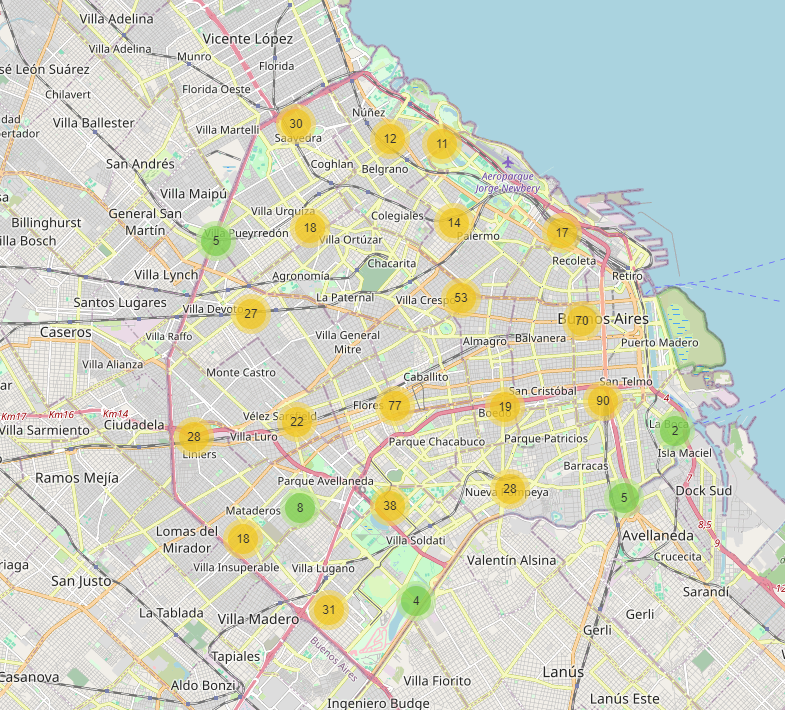

</center>

<center>

## Veamos los datos en escala de tiempo

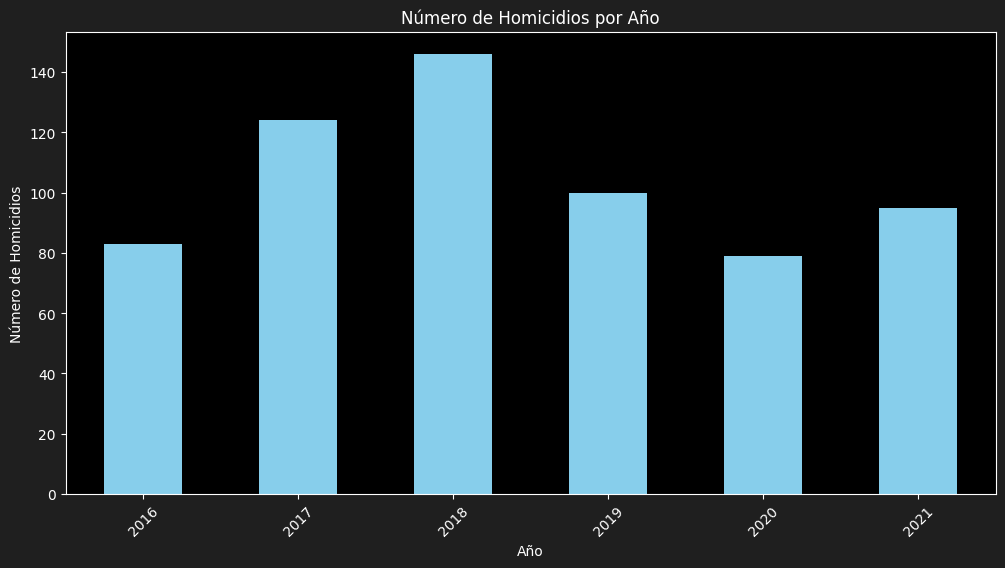

In [160]:

# Agrupa por año y cuenta el número de homicidios en cada año
homicidios_por_anio = homicidios.groupby(homicidios['fecha'].dt.year).size()

# Crea el gráfico de barras
plt.figure(figsize=(12, 6))
homicidios_por_anio.plot(kind='bar', color='skyblue')
plt.title('Número de Homicidios por Año')
plt.xlabel('Año')
plt.ylabel('Número de Homicidios')
plt.xticks(rotation=45)
plt.show()

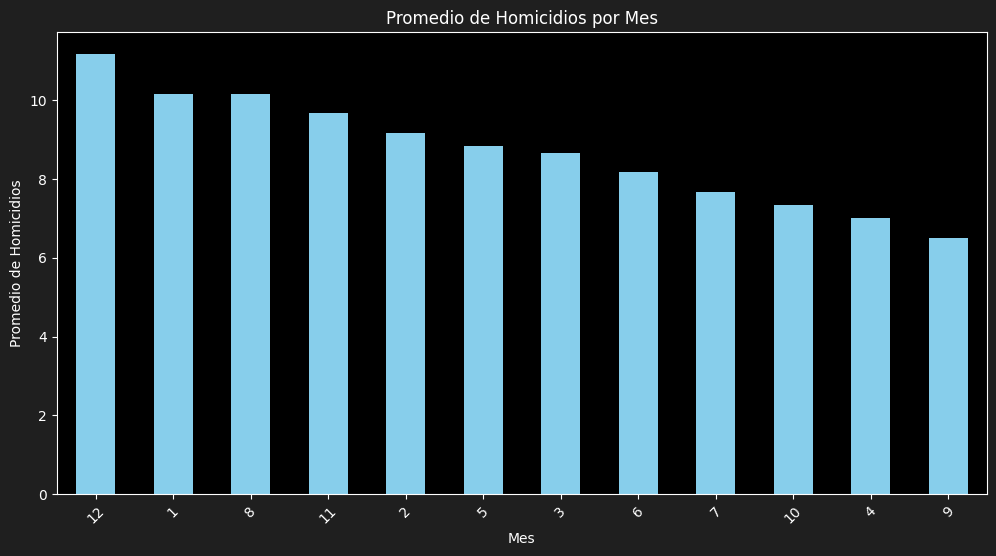

In [161]:
# Agrupa por mes y año, y cuenta el número de homicidios en cada grupo
homicidios_por_mes_y_anio = homicidios.groupby([homicidios['fecha'].dt.year, homicidios['fecha'].dt.month]).size()

# Convierte el índice a un objeto datetime para facilitar la manipulación
homicidios_por_mes_y_anio.index = pd.to_datetime(homicidios_por_mes_y_anio.index.map(lambda x: f'{x[0]}-{x[1]}'))

# Agrupa por mes y calcula el promedio de homicidios
promedio_homicidios_por_mes = homicidios_por_mes_y_anio.groupby(homicidios_por_mes_y_anio.index.month).mean()

# Ordena los meses de mayor a menor promedio de homicidios
promedio_homicidios_por_mes = promedio_homicidios_por_mes.sort_values(ascending=False)

# Crea el gráfico de barras
plt.figure(figsize=(12, 6))
promedio_homicidios_por_mes.plot(kind='bar', color='skyblue')
plt.title('Promedio de Homicidios por Mes')
plt.xlabel('Mes')
plt.ylabel('Promedio de Homicidios')
plt.xticks(rotation=45)
plt.show()

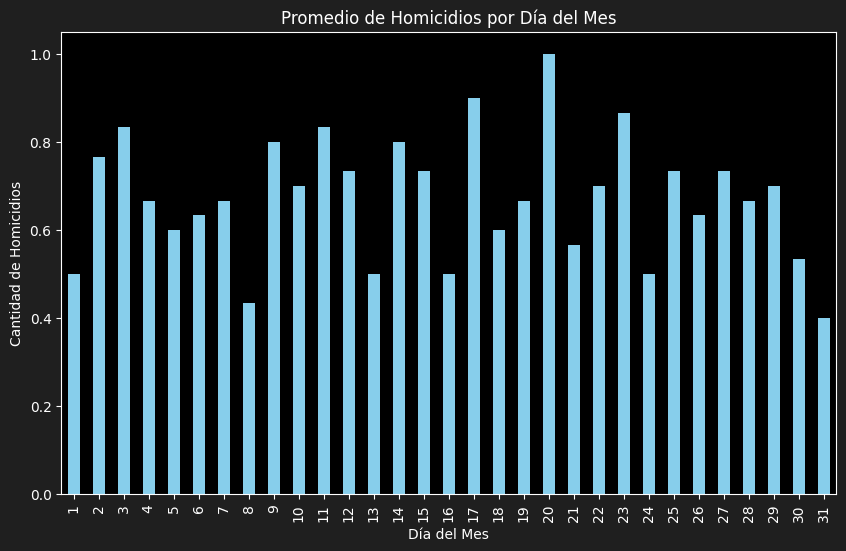

In [162]:
# Agrupa por día y cuenta la cantidad de homicidios por día
conteo_por_dia = homicidios.groupby(homicidios['fecha'].dt.day).size()
# Promedio por dia
promedio_por_dia=conteo_por_dia/30

# Crea un gráfico de barras
plt.figure(figsize=(10, 6))
promedio_por_dia.plot(kind='bar', color='skyblue')
plt.title('Promedio de Homicidios por Día del Mes')
plt.xlabel('Día del Mes')
plt.ylabel('Cantidad de Homicidios')
plt.show()

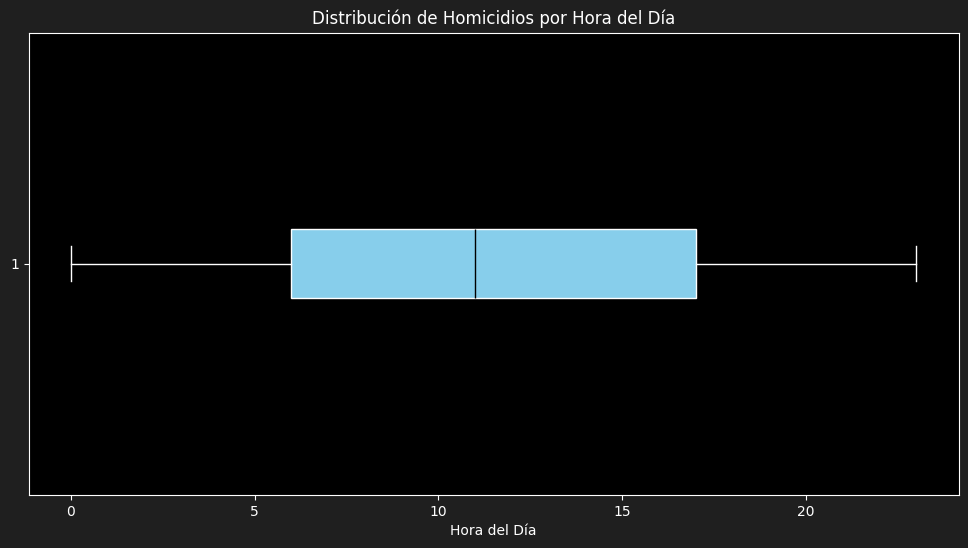

In [163]:
# Crea una lista de horas a partir de objetos datetime.time
horas = [hora.hour for hora in homicidios['hora']]

# Crea el gráfico de boxplot para la hora
plt.figure(figsize=(12, 6))
plt.boxplot(horas, vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'), medianprops=dict(color='black'))
plt.title('Distribución de Homicidios por Hora del Día')
plt.xlabel('Hora del Día')
# Personaliza el color de la caja
plt.show()

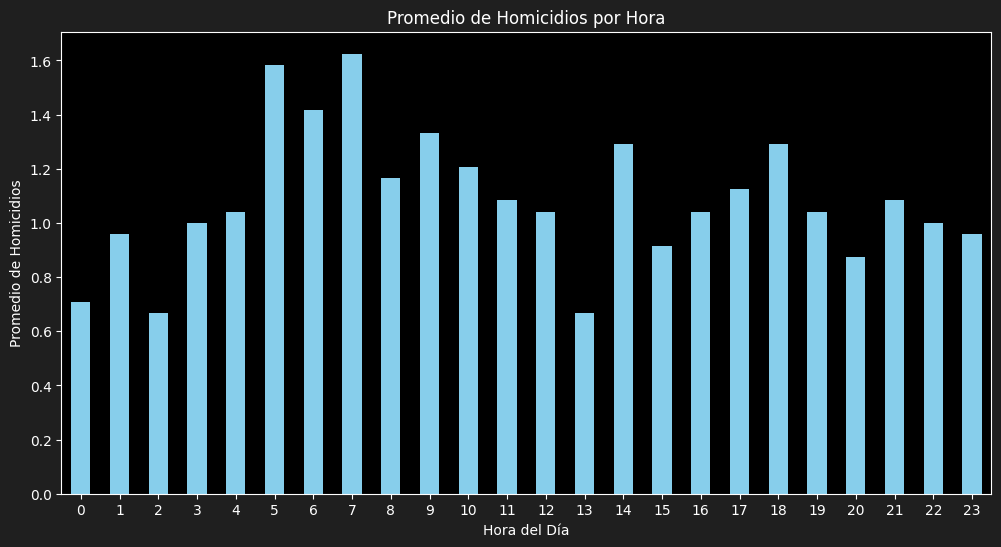

In [164]:
# Agrupa por hora
homicidios_por_hora = homicidios.groupby(homicidios['hora'].apply(lambda x: x.hour)).size()

#Calcula el promedio del número de homicidios en cada hora
promedio_homicidios_por_hora=homicidios_por_hora/24

# Crea el gráfico de barras
plt.figure(figsize=(12, 6))
promedio_homicidios_por_hora.plot(kind='bar', color='skyblue')
plt.title('Promedio de Homicidios por Hora')
plt.xlabel('Hora del Día')
plt.ylabel('Promedio de Homicidios')
plt.xticks(rotation=0)
plt.show()

<center>

## Veamos la distribucion por tipo de victima

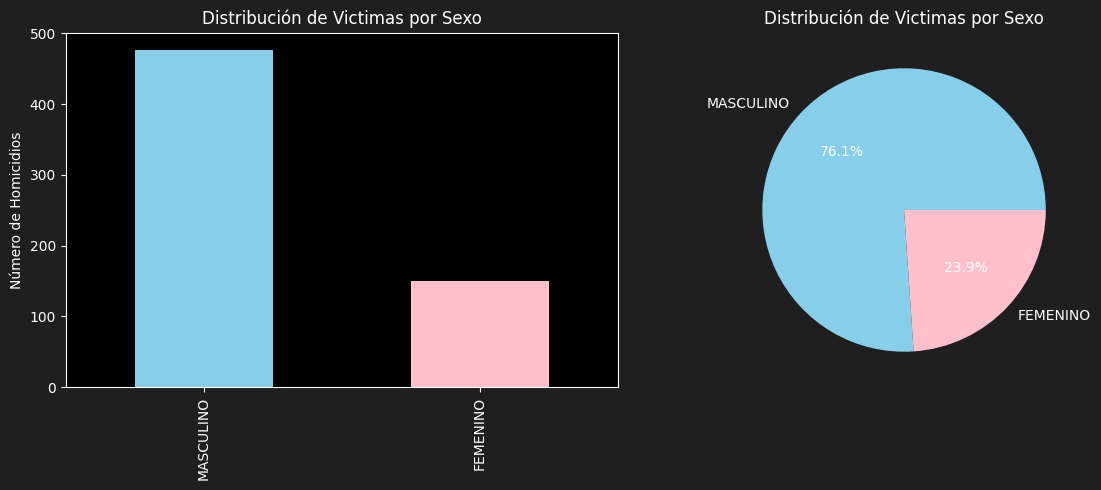

In [165]:
# Graficar barras para el sexo
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
homicidios['sexo'].value_counts().plot(kind='bar', color=['skyblue', 'pink'])
plt.title('Distribución de Victimas por Sexo')
plt.ylabel('Número de Homicidios')
plt.xlabel('')

# Graficar pastel para el sexo
plt.subplot(1, 2, 2)
homicidios['sexo'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'pink'])
plt.title('Distribución de Victimas por Sexo')
plt.ylabel('')

plt.tight_layout()
plt.show()

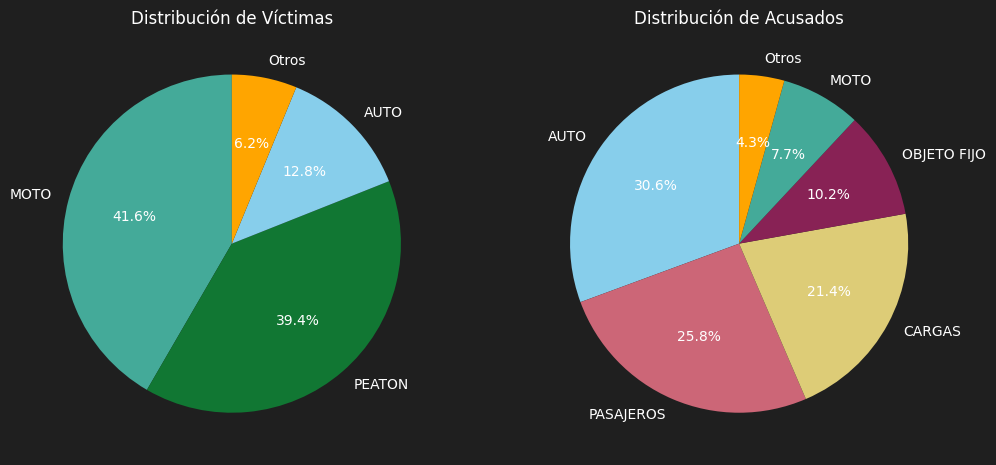

In [166]:
# Agregamos 'PEATON' a la lista de acusados
acusado_counts = homicidios['acusado'].value_counts()

# Contamos las ocurrencias de cada categoría
victima_counts = homicidios['victima'].value_counts()

# Establecemos un umbral para considerar las categorías como "Otros"
umbral = 0.05  # Puedes ajustar este umbral según tus necesidades

# Filtramos las categorías que tienen porcentajes bajos
victima_counts_filt = victima_counts[victima_counts / victima_counts.sum() > umbral]
acusado_counts_filt = acusado_counts[acusado_counts / acusado_counts.sum() > umbral]

# Agrupamos las categorías restantes en una categoría llamada "Otros"
victima_counts_filt['Otros'] = victima_counts[victima_counts / victima_counts.sum() <= umbral].sum()
acusado_counts_filt['Otros'] = acusado_counts[acusado_counts / acusado_counts.sum() <= umbral].sum()

# Definimos manualmente los colores para cada gráfica
colors_victima = ['#44aa99', '#117733', 'skyblue', 'orange']
colors_acusado = ['skyblue', '#cc6677', '#ddcc77', '#882255', '#44aa99', 'orange']

# Creamos gráficos de pastel para 'victima' y 'acusado'
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Gráfico de pastel para 'victima'
axes[0].pie(victima_counts_filt, labels=victima_counts_filt.index, autopct='%1.1f%%', startangle=90, colors=colors_victima)
axes[0].set_title('Distribución de Víctimas')

# Gráfico de pastel para 'acusado'
axes[1].pie(acusado_counts_filt, labels=acusado_counts_filt.index, autopct='%1.1f%%', startangle=90, colors=colors_acusado)
axes[1].set_title('Distribución de Acusados')

plt.show()

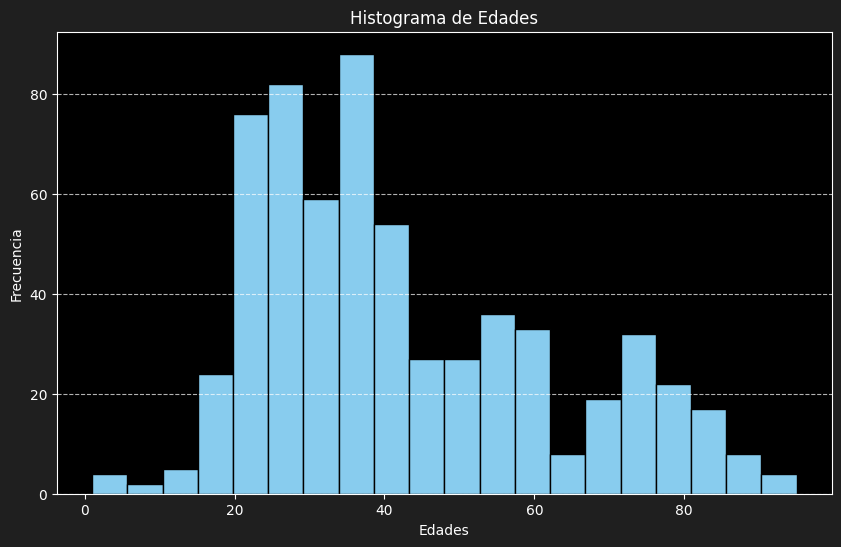

In [167]:
# Creamos el histograma de edades
plt.figure(figsize=(10, 6))
plt.hist(homicidios['edad'], bins=20, color='#88ccee', edgecolor='black')
plt.title('Histograma de Edades')
plt.xlabel('Edades')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()